<a href="https://colab.research.google.com/github/VVdovichev/Data_analysis_algorithms/blob/main/Lesson_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__1.__ Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [90]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

In [91]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [92]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [93]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

In [94]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [95]:
def residual(y, z):
    return - (z - y)

In [96]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [97]:
%%time
# Число деревьев в ансамбле
n_trees = np.arange(1, 13, 3)

# Максимальная глубина деревьев
max_depth = np.arange(1, 13, 3)

# Шаг
eta = 1
trees = []
depth = []
mse = []
for i in n_trees:
  for j in max_depth:
    trees.append(i)
    depth.append(j)
    mse.append(list(gb_fit(i, j, X_train, X_test, y_train, y_test, eta))[2][-1])

CPU times: user 17.1 s, sys: 1.24 s, total: 18.3 s
Wall time: 16.9 s


No handles with labels found to put in legend.


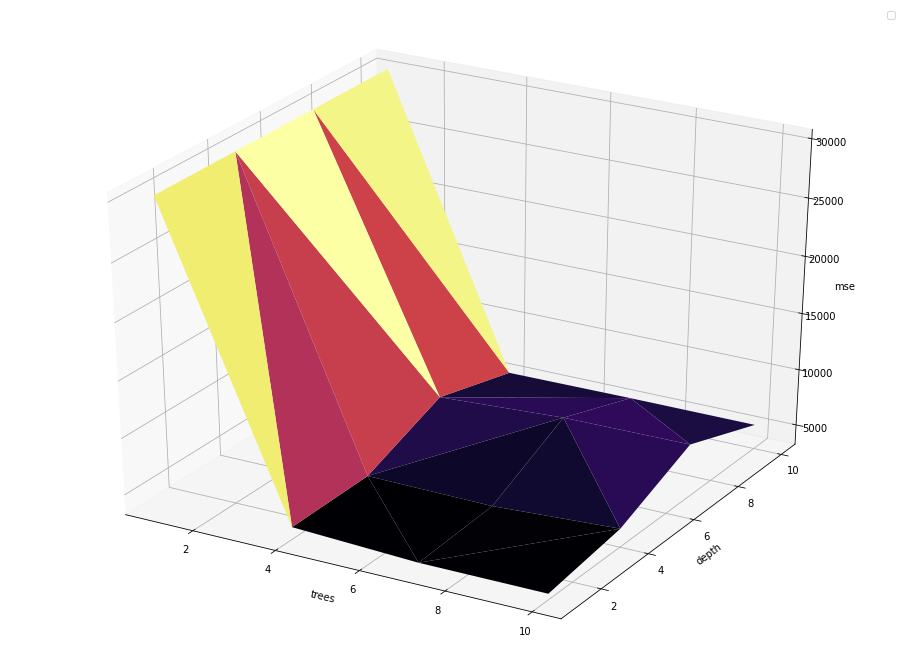

In [98]:
fig = plt.figure(figsize=([16, 12]))
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(trees, depth, mse, cmap='inferno')
ax.set_xlabel('trees')
ax.set_ylabel('depth')
ax.set_zlabel('mse')

ax.legend()


Вывод: при малом кол-ве деревьев и большой глубине происходит увелечение среднеквадратичной ошибки.

__2.__ * Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [99]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            indices = np.random.choice(len(X_train) - 1, len(X_train) // 2)  # changed
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[indices], residual(y_train[indices], target[indices]))   # changed
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [100]:
%%time
# Число деревьев в ансамбле
n_trees = np.arange(1, 13, 3)

# Максимальная глубина деревьев
max_depth = np.arange(1, 13, 3)

# Шаг
eta = 1
trees_s = []
depth_s = []
mse_s = []
for i in n_trees:
  for j in max_depth:
    trees_s.append(i)
    depth_s.append(j)
    mse_s.append(list(sgb_fit(i, j, X_train, X_test, y_train, y_test, eta))[2][-1])

CPU times: user 17.2 s, sys: 1.3 s, total: 18.5 s
Wall time: 16.9 s


No handles with labels found to put in legend.


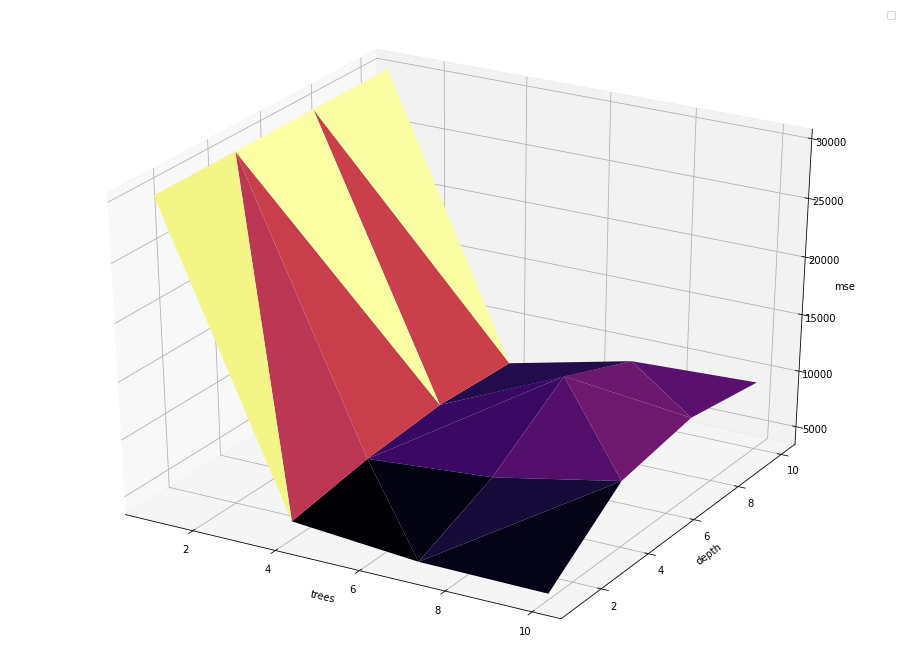

In [101]:
fig = plt.figure(figsize=([16, 12]))
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(trees_s, depth_s, mse_s, cmap='inferno')
ax.set_xlabel('trees')
ax.set_ylabel('depth')
ax.set_zlabel('mse')

ax.legend()
